# \[Note\] DGX station 설정_메모 추가

GUEBIN CHOI  
2023-11-22

<font color=green>MIG = Multi Instance GPU</font>

<font color=green>gi = GPU Instance $\rightarrow$ 가상의 GPU</font>

<font color=green>nvidia-smi mig $\rightarrow$ 도움말 보기</font>

# 1. MIG

## A. MIG 모드 enable

`-` root 획득

``` bash
sudo -i 
```

<font color=green>$\rightarrow$ 관리자 권한 획득</font>

`-` 모든 GPU enable

``` bash
nvidia-smi -mig 1 
sudo systemctl stop nvidia-mig-manager.service
sudo systemctl disable nvidia-mig-manager.service
reboot
```

``` bash
nvidia-smi -mig 1 
```

<font color=green>$\rightarrow$ 여기서 1은 모든 GPU를 의미하는 듯? 즉,
모든 GPU를 mig 모드로 하겠다는 뜻</font>

<font color=green>$\rightarrow$ mig 모드 해서 GPU를 나누지 않아도
사용하기 때문에, mig 모드 다 해놔도 괜찮~</font>

`-` 모든 특정 GPU만 enable

``` bash
#nvidia-smi -i {GPUdev-ID} -mig 1
nvidia-smi -i 0 -mig 1 
sudo systemctl stop nvidia-mig-manager.service
sudo systemctl disable nvidia-mig-manager.service
reboot 
```

<font color=green>$\rightarrow$ 왜인진 모르지만.. 위 sudo~ 를
실행해주어야 함..</font>

`-` GPU가 MIG 모드로 되면 아래와 같이 GPU-Util 에 `N/A`로 표시된다.
아래는 0,1,2,4 에 대응하는 GPU가 MIG모드로 설정된 상태임

<figure>
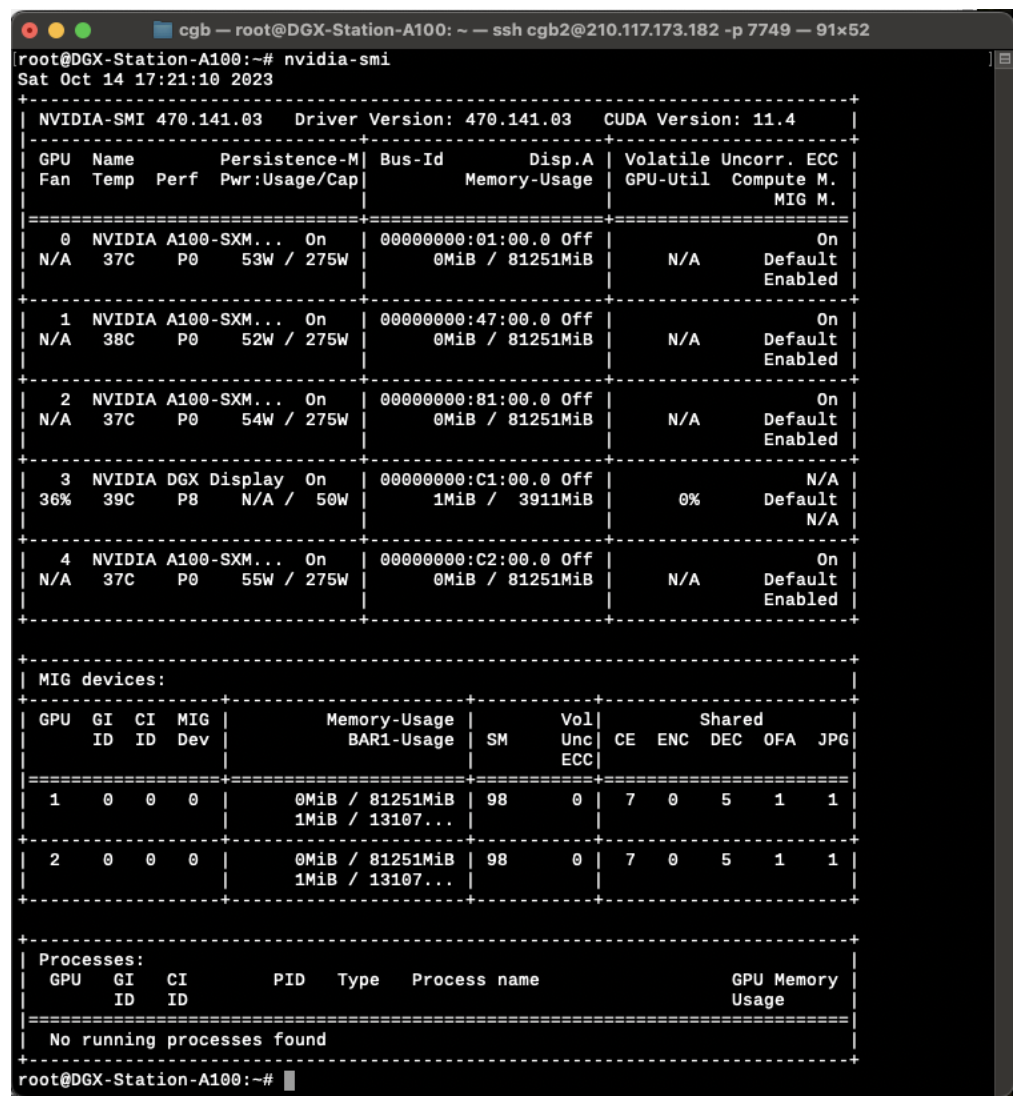
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.55.06.png</figcaption>
</figure>

<font color=green>$\rightarrow$ 여기에 0,1,2,4의 GPU가 있고, 3은 아님.
GPU를 gi로 나누면 MIG deviced에 나타남.</font>

<font color=green>$\rightarrow$ 단, 나중에 이 4의 GPU는 3으로 보고 gi
만들어야 함.</font>

## B. GPU, GI, CI 확인

`-` 용어정리

-   GPU: 말 그대로 GPU
-   GI: GPU INSTANCE, 하나의 GPU에 여러개의 GPU INSTANCE가 존재할 수
    있음.
-   CI: COMPUTE INSTANCE, 하나의 GPU INSTANCE에 여러개의 COMPUTE
    INSTANCE를 만들 수 있음.

`-` 상황확인

``` bash
nvidia-smi 
```

<figure>
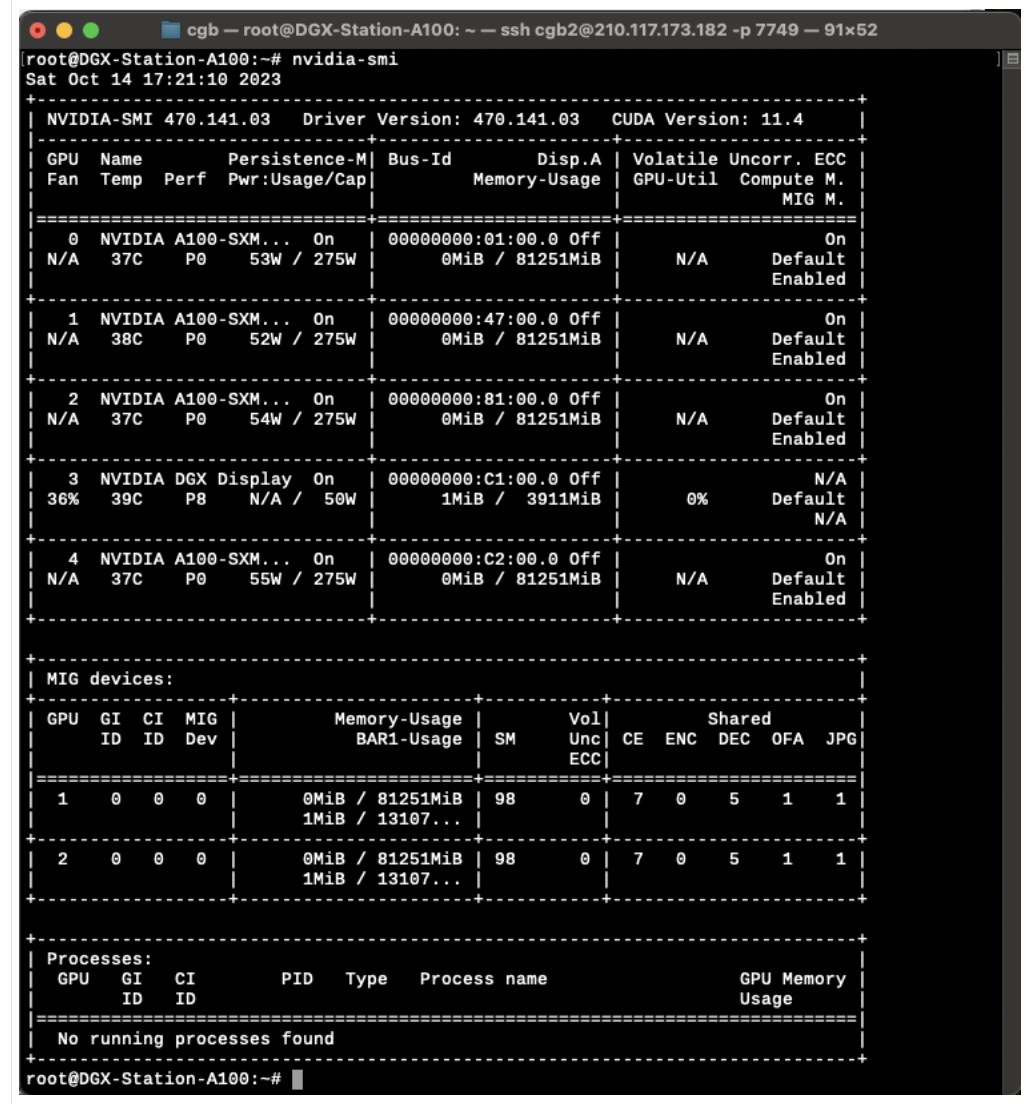
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.53.41.png</figcaption>
</figure>

`-` GPU의 해석

    +-----------------------------------------------------------------------------+
    | NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
    |-------------------------------+----------------------+----------------------+
    | GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
    | Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
    |                               |                      |               MIG M. |
    |===============================+======================+======================|
    |   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                   On |
    | N/A   37C    P0    53W / 275W |      0MiB / 81251MiB |     N/A      Default |
    |                               |                      |              Enabled |
    +-------------------------------+----------------------+----------------------+
    |   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off |                   On |
    | N/A   38C    P0    52W / 275W |      0MiB / 81251MiB |     N/A      Default |
    |                               |                      |              Enabled |
    +-------------------------------+----------------------+----------------------+
    |   2  NVIDIA A100-SXM...  On   | 00000000:81:00.0 Off |                   On |
    | N/A   37C    P0    54W / 275W |      0MiB / 81251MiB |     N/A      Default |
    |                               |                      |              Enabled |
    +-------------------------------+----------------------+----------------------+
    |   3  NVIDIA DGX Display  On   | 00000000:C1:00.0 Off |                  N/A |
    | 36%   39C    P8    N/A /  50W |      1MiB /  3911MiB |      0%      Default |
    |                               |                      |                  N/A |
    +-------------------------------+----------------------+----------------------+
    |   4  NVIDIA A100-SXM...  On   | 00000000:C2:00.0 Off |                   On |
    | N/A   37C    P0    55W / 275W |      0MiB / 81251MiB |     N/A      Default |
    |                               |                      |              Enabled |
    +-------------------------------+----------------------+----------------------+

총 4개의 GPU가 있으며 아이디는 0,1,2,4 임을 알 수 있다.

`-` `GPUdev-ID`, `GI-ID`, `CI-ID`, `MIGdev-ID` 확인

    +-----------------------------------------------------------------------------+
    | MIG devices:                                                                |
    +------------------+----------------------+-----------+-----------------------+
    | GPU  GI  CI  MIG |         Memory-Usage |        Vol|         Shared        |
    |      ID  ID  Dev |           BAR1-Usage | SM     Unc| CE  ENC  DEC  OFA  JPG|
    |                  |                      |        ECC|                       |
    |==================+======================+===========+=======================|
    |  1    0   0   0  |      0MiB / 81251MiB | 98      0 |  7   0    5    1    1 |
    |                  |      1MiB / 13107... |           |                       |
    +------------------+----------------------+-----------+-----------------------+
    |  2    0   0   0  |      0MiB / 81251MiB | 98      0 |  7   0    5    1    1 |
    |                  |      1MiB / 13107... |           |                       |
    +------------------+----------------------+-----------+-----------------------+

아래와 같은 상황을 유추할 수 있다.

| GPUdev ID | GI ID   | CI ID    | MIGdev ID |
|-----------|---------|----------|-----------|
| 1         | 0 (80G) | 0 (98SM) | 0         |
| 2         | 0 (80G) | 0 (98SM) | 0         |

`-` 생성가능한 gi 확인

<figure>
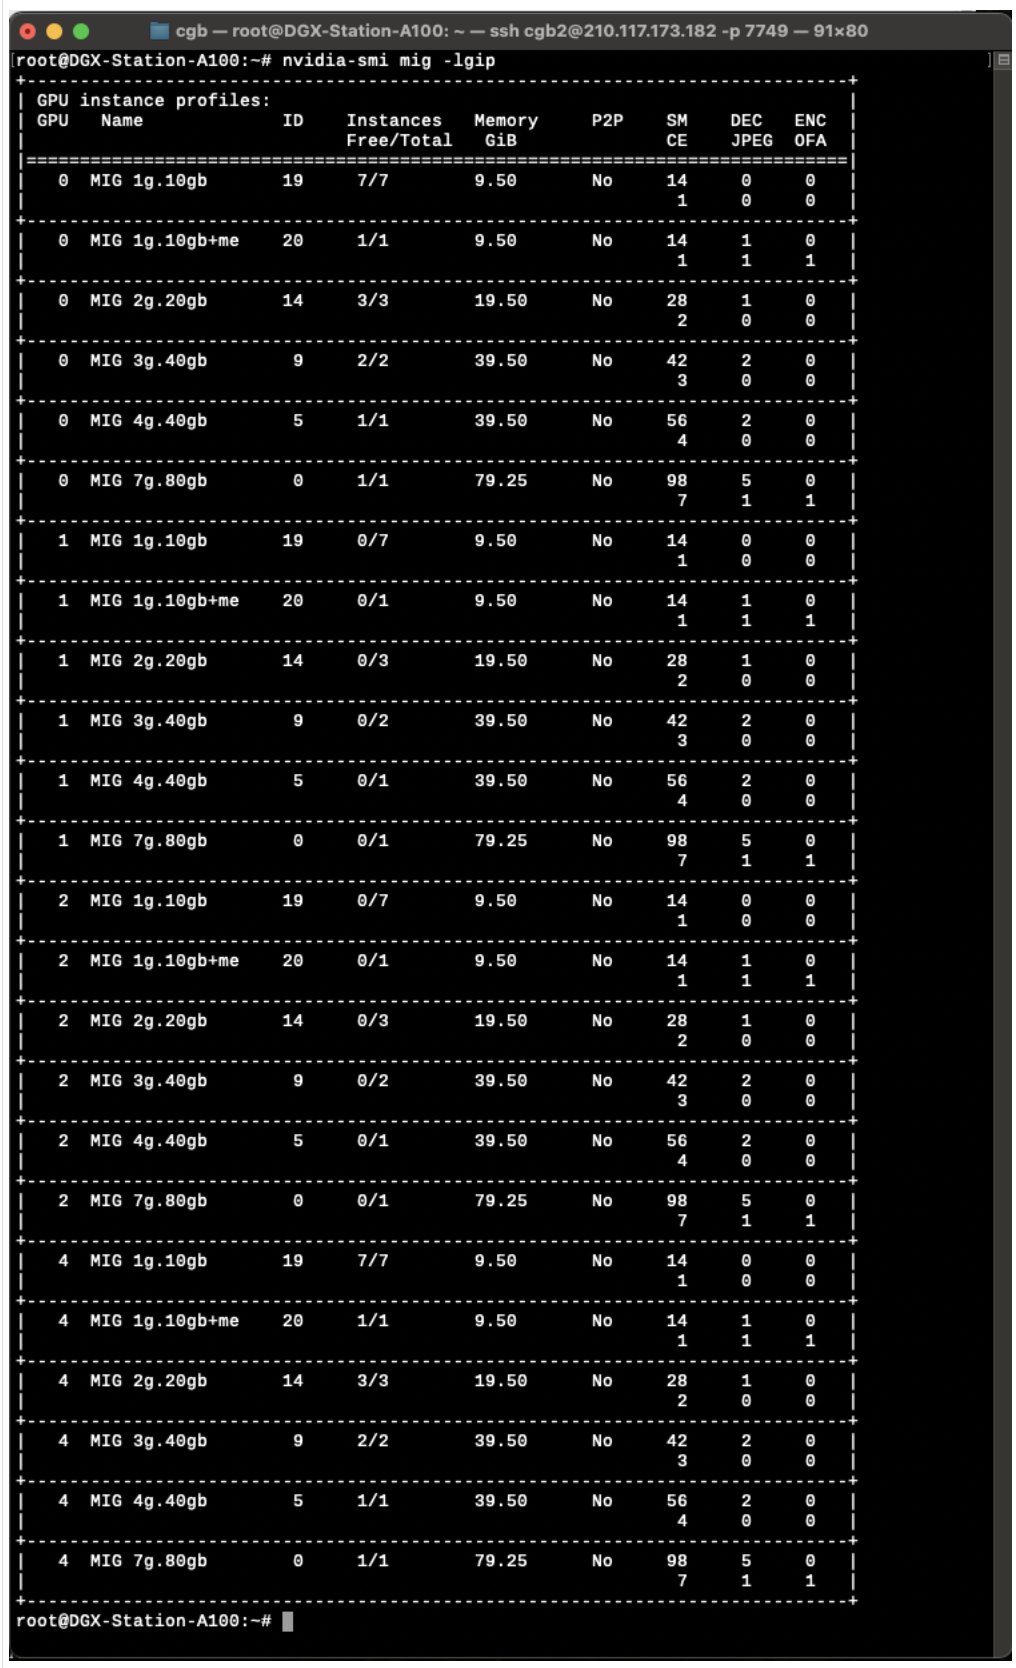
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.56.00.png</figcaption>
</figure>

`-` 생성가능한 ci 확인

<figure>
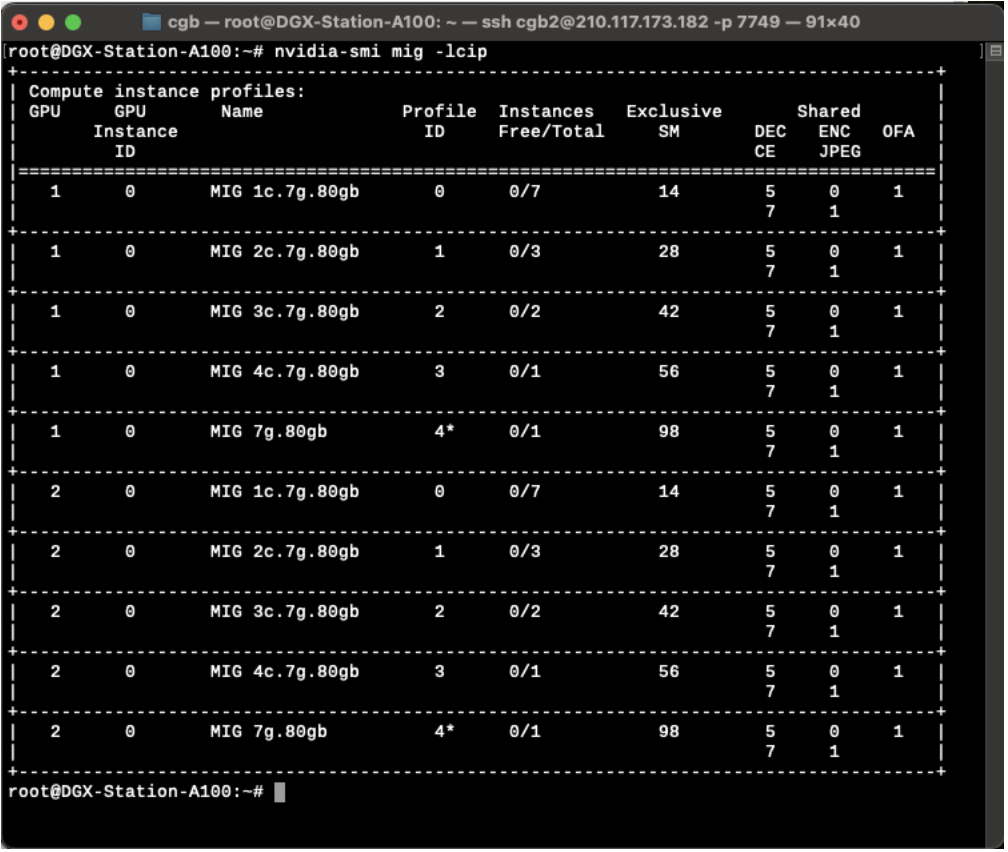
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.56.31.png</figcaption>
</figure>

<font color=green>$\rightarrow$ cgi = create GPU Instance</font>

<font color=green>$\rightarrow$ lgip = list of GPU Instance
Profiles</font>

## C. GI 생성

`-` `GPUdev` = 4 에서 생성가능한 `GI` 조회

``` bash
#nvidia-smi mig -i {GPUdev-ID} -lgip
nvidia-smi mig -i 4 -lgip
```

<figure>
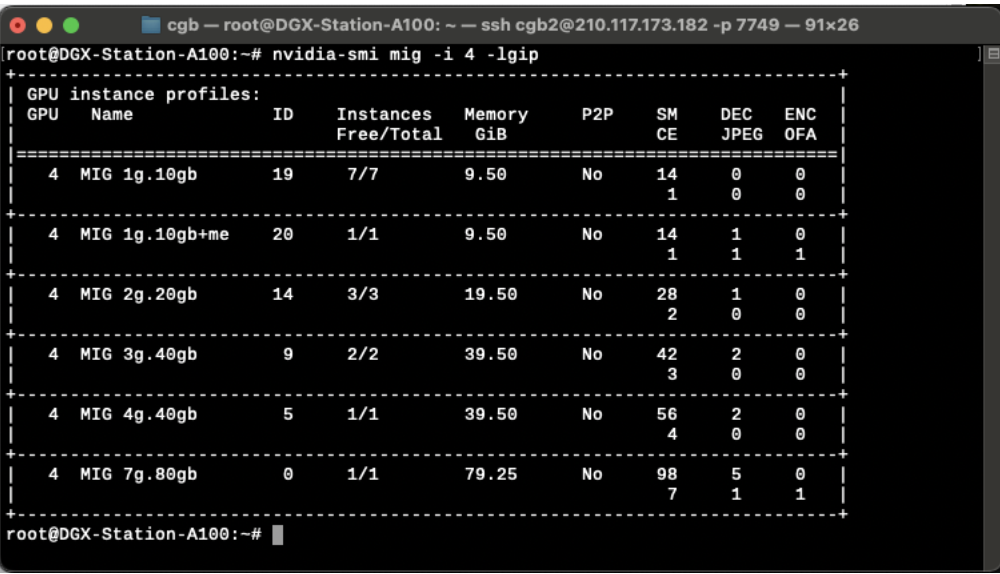
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.57.01.png</figcaption>
</figure>

`-` 아래에 해당하는 `GI`를 2개 생성하고 싶다고 하자.
(`GPU-INSTANCE-PROFILE-ID`=9 임을 유의)

    +-----------------------------------------------------------------------------+
    | GPU instance profiles:                                                      |
    | GPU   Name             ID    Instances   Memory     P2P    SM    DEC   ENC  |
    |                              Free/Total   GiB              CE    JPEG  OFA  |
    |=============================================================================|
    |   4  MIG 3g.40gb        9     0/2        39.50      No     42     2     0   |
    |                                                             3     0     0   |
    +-----------------------------------------------------------------------------+

``` bash
#nvidia-smi mig -i {GPUdev-ID} -cgi {GPU-INSTANCE-PROFILE-ID}
nvidia-smi mig -i 4 -cgi 9 
nvidia-smi mig -i 4 -cgi 9 
```

<figure>
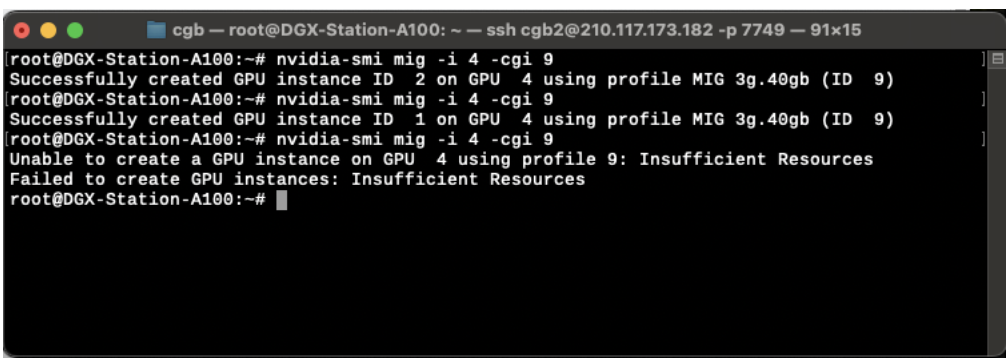
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.57.29.png</figcaption>
</figure>

> 2개까지는 잘 만들어지고 그 이후에는 리소스부족으로 에러발생

`-` 만들어진 `GI` 확인

<figure>
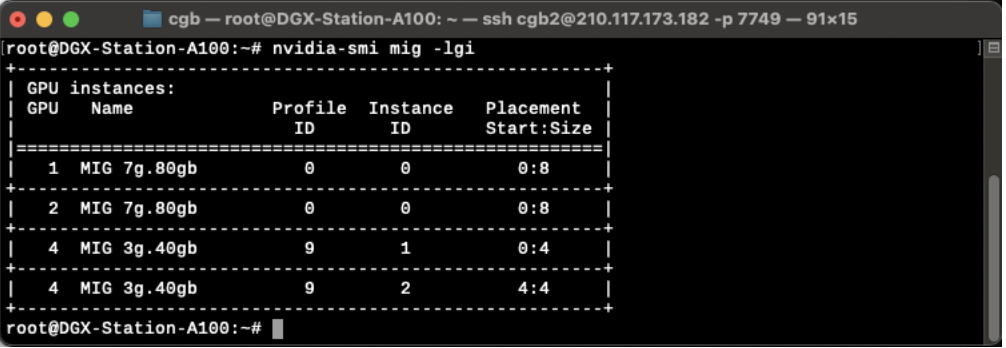
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.57.49.png</figcaption>
</figure>

`-` 생성가능한 `CI` 확인

``` bash
nvidia-smi mig -lcip
```

-   Note: {GPU ID: GPU INSTANCE ID} 의 조합에서 {1:0}, {2:0}, {4:1},
    {4:2}에 해당하는 GI에서 생성가능한 CI들이 각각 출력된다. 4번 GPU의
    GI들은 40기가가 한계이므로 생성가능 CI목록이 상대적으로 제한적임을
    캐치하라

<figure>
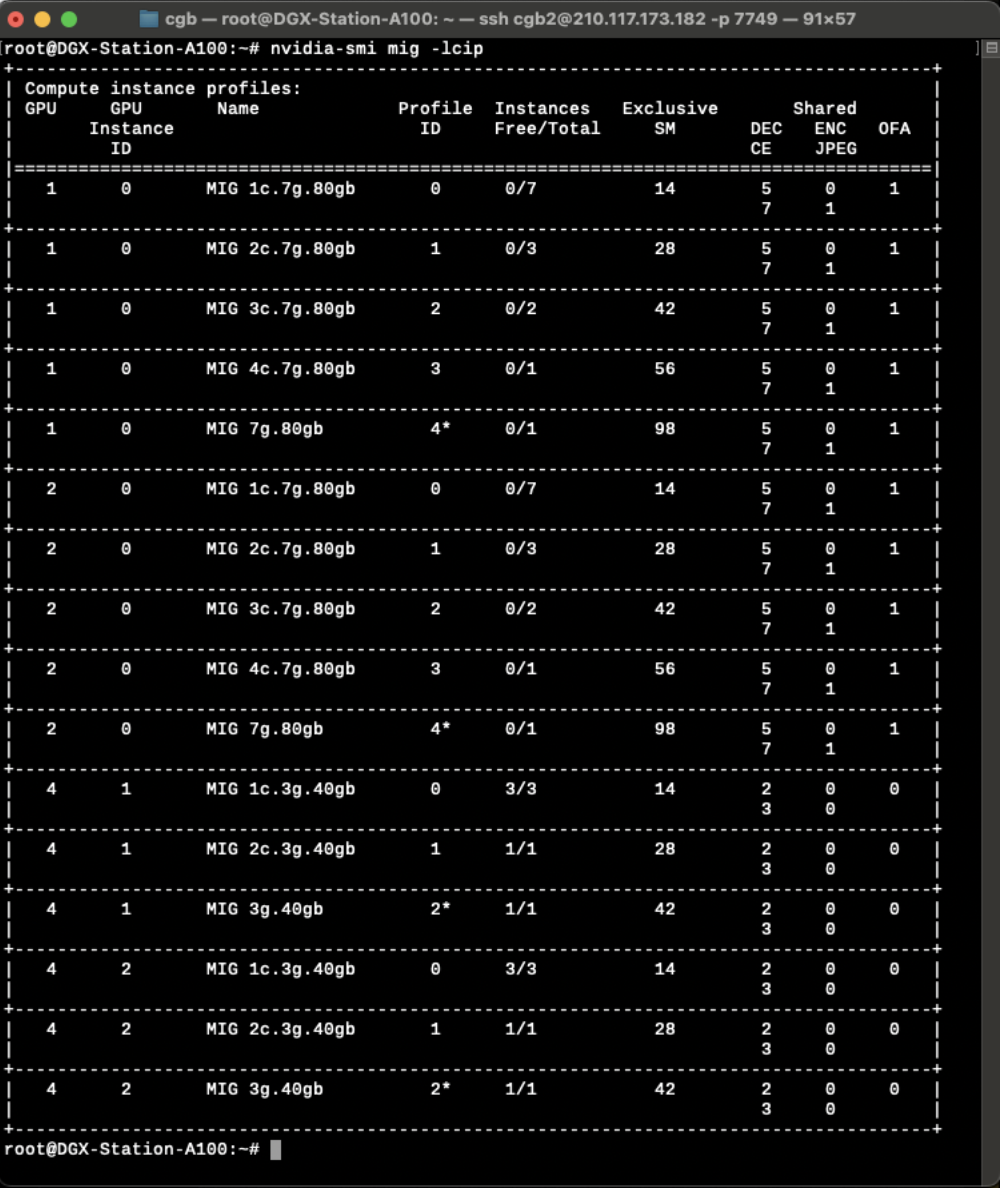
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.58.10.png</figcaption>
</figure>

## D. CI 생성

`-` `GPUdev`=4 에서 생성가능한 `CI` 조회

``` bash
#nvidia-smi mig -i {GPU ID} -lcip
nvidia-smi mig -i 4 -lcip
```

-   Note: 각 GPU-인스턴스(GI)에서는 3개 계산-인스턴스(CI)를 만들수 있음.
    만약에 `Profile ID = 0` 으로 만든다면 14의 계산능력을 가진 CI를
    3개까지 만들수 있음, 만약 `Profile ID = 2*` 로 만든다면 42개의
    계산능력을 가진 CI를 1개만 만들 수 있음

<figure>
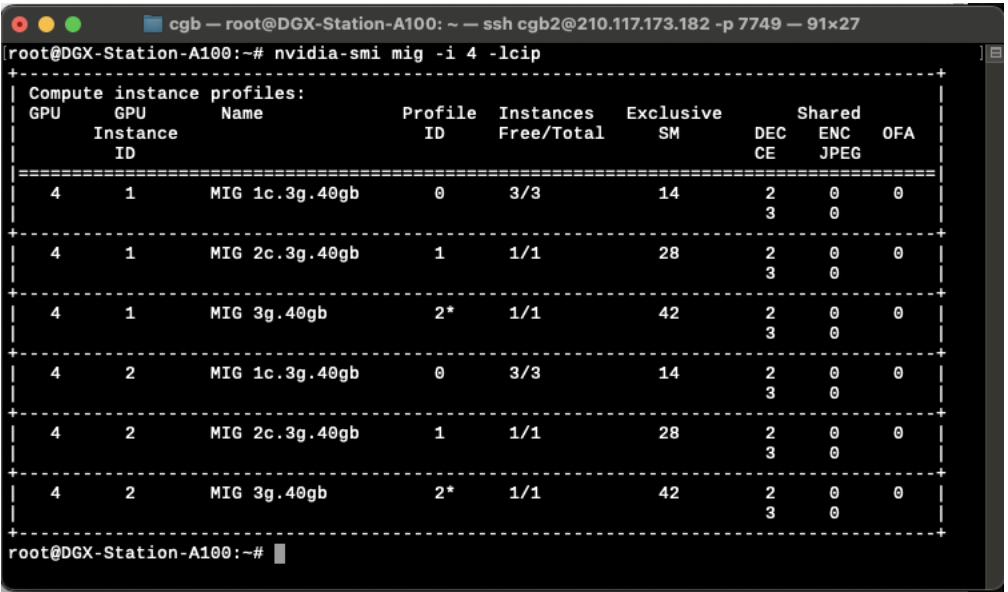
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.59.01.png</figcaption>
</figure>

`-` {`GPUdev-ID`:`GI-ID`} = {4:1} 에서 `COMPUTE-INSTANCE-PROFILE-ID`=0
에 해당하는 CI를 3개 생성

``` bash
#nvidia-smi mig -i {GPUdev-ID} -gi {GI-ID} -cci {COMPUTE-INSTANCE-PROFILE-ID}
nvidia-smi mig -i 4 -gi 1 -cci 0
```

-   Note: 자원부족으로 3개까지 밖에 못만든다..

<figure>
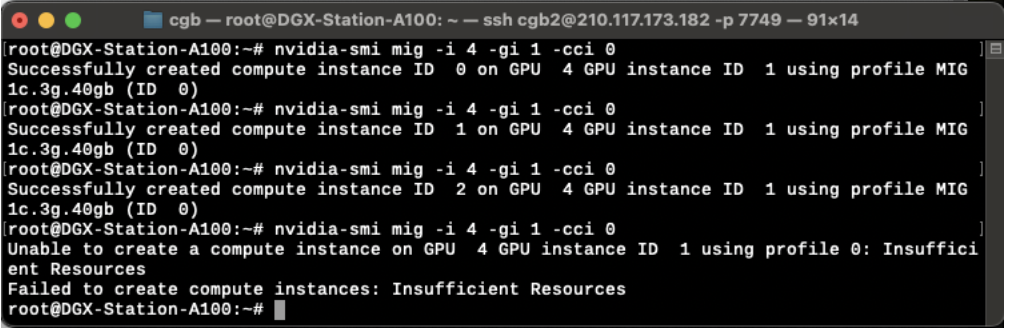
<figcaption aria-hidden="true">Screenshot 2023-11-22 at
23.59.39.png</figcaption>
</figure>

`-` {`GPUdev-ID`:`GI-ID`}={4:2} 에서 `COMPUTE-INSTANCE-PROFILE-ID`=2 에
해당하는 CI를 1개 생성

``` bash
#nvidia-smi mig -i {GPUdev-ID} -gi {GI-ID} -cci {COMPUTE-INSTANCE-PROFILE-ID}
nvidia-smi mig -i 4 -gi 2 -cci 2 
```

-   Note: 자원이 부족해서 1개밖에 못 만든다.

<figure>
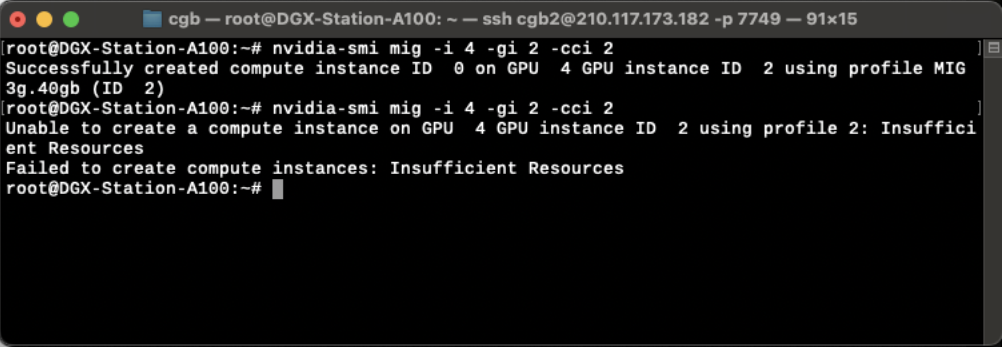
<figcaption aria-hidden="true">Screenshot 2023-11-23 at
00.00.18.png</figcaption>
</figure>

`-` 현재 상황

<figure>
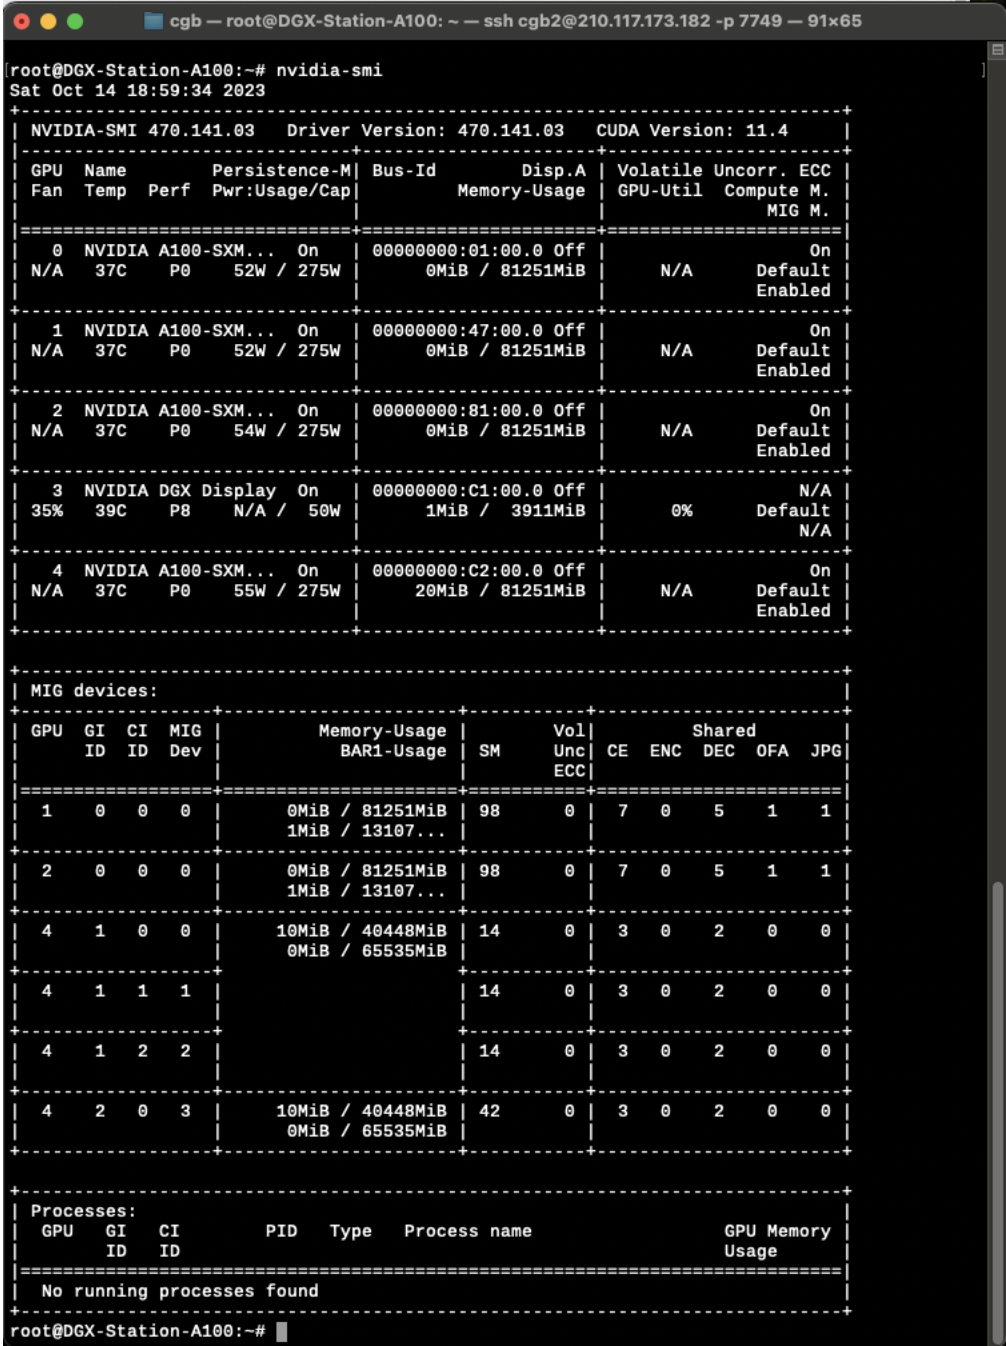
<figcaption aria-hidden="true">Screenshot 2023-11-23 at
00.01.04.png</figcaption>
</figure>

| GPUdev ID | GI ID   | CI ID    | MIGdev ID |
|-----------|---------|----------|-----------|
| 1         | 0 (80G) | 0 (98SM) | 0         |
| 2         | 0 (80G) | 0 (98SM) | 0         |
| 4         | 1 (80G) | 0 (14SM) | 0         |
| 4         | 1 (80G) | 1 (14SM) | 1         |
| 4         | 1 (80G) | 2 (14SM) | 2         |
| 4         | 2 (80G) | 0 (42SM) | 3         |

# 2. DOCKER

## A. 컨테이너 생성

`-` 아래와 같은 방식으로 컨테이너 생성

``` bash
# nvidia-docker run --gpus '"device={GPUdev-ID}:{MIGdev-ID}"' -ti --rm -d -t -p {HOST-PORT}:{CONTAINER-PORT} {DOCKER-IMAGE-NAME} /bin/bash
nvidia-docker run --gpus '"device=1:0"' -ti --rm -d -t -p 7749:7749  -p 1307:1307 ubuntu /bin/bash
nvidia-docker run --gpus '"device=2:0"' -ti -d -t -p 4653:4653  -p 1212:1212 -p 1213:1213 -p 1214:1214 ubuntu /bin/bash
```

-   `-ti`: 컨테이너를 대화형(interactive) 모드로 실행. 이 모드에서
    컨테이너와 상호작용할 수 있음.
-   `--rm`: 컨테이너가 종료되면 자동으로 컨테이너를 삭제. 이 옵션을
    사용하면 컨테이너를 실행한 후 자동으로 정리.
-   `-d`: 컨테이너를 백그라운드(background) 모드로 실행. 이 옵션을
    사용하면 컨테이너가 백그라운드에서 실행되며 터미널이 차지되지 않음.
-   `-t`: 컨테이너에 tty (터미널)를 할당. 이것은 대화형 모드와 함께
    사용.
-   `/bin/bash`: 컨테이너가 시작될 때 실행할 명령어. 이 경우, Bash 셸을
    실행.

<font color=green>docker start$\rightarrow$ DOCKER 시작</font>

<font color=green>docker ps$\rightarrow$ 실행중인 DOCKER container list,
ps = process status</font>

<font color=green>docker ps -a$\rightarrow$ 실행중인 DOCKER container
list + stop된 container까지 모두</font>

<font color=green>docker image ls$\rightarrow$ 다운로드한 이미지
목록</font>

``` bash
nvidia-docker run --gpus '"device=2:0"' -ti -d -t -p 4653:4653  -p 1212:1212 ubuntu /bin/bash
```

<font color=green>$\rightarrow$ gpus 플래그라고 하는데 잘
모르겠음..</font>

<font color=green>$\rightarrow$ device에서 2번 ID의 0번 gi를
의미함</font>

## B. 컨테이너 실행

``` bash
docker exec -ti {CONTAINER-ID} bash
```

> 여기에서 `{CONTAINER-ID}`는 `docker ps` 혹은 `docker ps -a`로
> 확인한다.

# 3. UBUNTU

## A. `passwd`

`-` 아래를 실행하여 비밀번호를 바꿀것

``` bash
passwd root
```

## B. update

`-` 아래를 실행

``` bash
apt update 
apt install gcc
apt install build-essential
```

<font color=green>업데이트 해야 `vim` 설치 되더라구 </font>

## C. 쓸만한 패키지 설치

`-` 아래를 설치하면 좋음..

``` bash
apt install vim 
apt install openssh-server
apt install git
```

## D. `ssh`

``` bash
# apt install openssh-server
vi /etc/ssh/sshd_config 
```

    Port {My-SSH-Port}
    PermitRootLogin yes
    PasswordAuthentication yes

``` bash
service ssh restart
```

<font color=green>vi는 에디터임, `i`누르면 수정하는 거고 `esc`누르면
나옴.</font>

<font color=green>`shift` + `;`로 `:` 만들면 text 작성 칸 나오는데,
`q`하면 나오기 `wq`하면 저장하고 나오기 `q!`하면 강제 종료하기 임</font>

<font color=green>수정하고 그냥 `q`하려하면 안 나와진다.</font>

## E. anaconda

`-`
[여기참고..](https://miruetoto.github.io/yechan3/posts/4_Notes/2000-01-02-%EC%9A%B0%EB%B6%84%ED%88%AC%20%ED%8F%AC%EB%A7%B7%20%EB%B0%8F%20%EA%B0%9C%EB%B0%9C%EC%9A%A9%20%EC%84%9C%EB%B2%84%20%EC%85%8B%ED%8C%852.html#%EC%95%84%EB%82%98%EC%BD%98%EB%8B%A4)

## F. vscode

`-` 아래를 이용하여 설치

``` bash
curl -Lk 'https://code.visualstudio.com/sha/download?build=stable&os=cli-alpine-x64' --output vscode_cli.tar.gz
tar -xf vscode_cli.tar.gz
```

`-` 아래를 이용하여 초기 설정 (깃헙아이디로 인증)

``` bash
./code tunnel 
```

`-` 초기설정 이후 아래를 이용하여 백그라운드에서 실행

``` bash
nohup ./code tunnel &
```

## G. Jupyter

`-` 암호설정:
[여기로..](https://miruetoto.github.io/yechan3/posts/4_Notes/2000-01-02-%EC%9A%B0%EB%B6%84%ED%88%AC%20%ED%8F%AC%EB%A7%B7%20%EB%B0%8F%20%EA%B0%9C%EB%B0%9C%EC%9A%A9%20%EC%84%9C%EB%B2%84%20%EC%85%8B%ED%8C%852.html#a.-%EC%A3%BC%ED%94%BC%ED%84%B0-%EC%9B%90%EA%B2%A9%EC%A0%9C%EC%96%B4-%EC%84%A4%EC%A0%95)

`-` 주피터 실행할때 아래로 실행

``` bash
jupyter lab --ip="0.0.0.0" --port={MY-PORT} --no-browser --allow-root
```